In [47]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
import sympy as sp
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [48]:
# Get data from MG5 runs
pclFiles = {'pp->zp': '../data/2mdm_zp_jet.pcl',
            'pp->sd': '../data/2mdm_sd_jet.pcl'}

df = [pd.read_pickle(f) for l, f in pclFiles.items()]

for i, label in enumerate(pclFiles.keys()):
    df[i]['process'] = label
    
    if label == 'pp->zp':
        df[i] = df[i].drop(columns=['$m_{s}$'])
        df[i] = df[i].rename(columns={'$m_{Z^{\prime}}$': '$m_{med}$'})
        
    elif label == 'pp->sd':
        df[i] = df[i].drop(columns=['$m_{Z^{\prime}}$'])
        df[i] = df[i].rename(columns={'$m_{s}$': '$m_{med}$'})
    
for d in df:
    d = d.sort_values(['process', '$m_{med}$', '$\sin\\theta$', '$g_{q}$'],inplace=True, 
                     ascending=[True, True, True, True])

In [49]:
data = pd.DataFrame()
for d in df:
    data = pd.concat((data,d))

In [50]:
BRdata = pd.read_pickle('../data/BRdata.pcl')

In [51]:
dataS = data[data['process'] == 'pp->sd']
dataZ = data[data['process'] == 'pp->zp']
brS = BRdata[BRdata['Mediator'] == '$S_{d}$']
brZ = BRdata[BRdata['Mediator'] == '$Z^{\prime}$']

In [52]:
col = ['$m_{med}$', '$\\sin\\theta$']

keys = list(dataS[col].columns.values)
i1 = dataS.set_index(keys).index
i2 = brS.set_index(keys).index
brS = brS[i2.isin(i1)]

col = ['$m_{med}$', '$g_{q}$']

keys = list(dataZ[col].columns.values)
i1 = dataZ.set_index(keys).index
i2 = brZ.set_index(keys).index
brZ = brZ[i2.isin(i1)]

In [53]:
# Filter models

filter1 = {'$y_{\\chi}$': 1.5}
filter2 = {'$g_{\\chi}$': 1.0}
filter3 = {'$\\sin\\theta$': 0.2}
filter4 = {'$g_{q}$': 0.1}

str1 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter1.items()])
str2 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter2.items()])
str3 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter3.items()])
str4 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter4.items()])
textstr = '\n'.join([str1]+[str2]+[str3]+[str4])

dataS = dataS.loc[(dataS[list(filter3)] == pd.Series(filter3)).all(axis=1)]
brS = brS.loc[(brS[list(filter1)] == pd.Series(filter1)).all(axis=1)]
brS = brS.loc[(brS[list(filter3)] == pd.Series(filter3)).all(axis=1)]

dataZ = dataZ.loc[(dataZ[list(filter4)] == pd.Series(filter4)).all(axis=1)]
brZ = brZ.loc[(brZ[list(filter2)] == pd.Series(filter2)).all(axis=1)]
brZ = brZ.loc[(brZ[list(filter4)] == pd.Series(filter4)).all(axis=1)]

print(len(dataS), len(brS), len(dataZ), len(brZ))

14 14 26 26


In [54]:
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(pclFiles.keys())}    

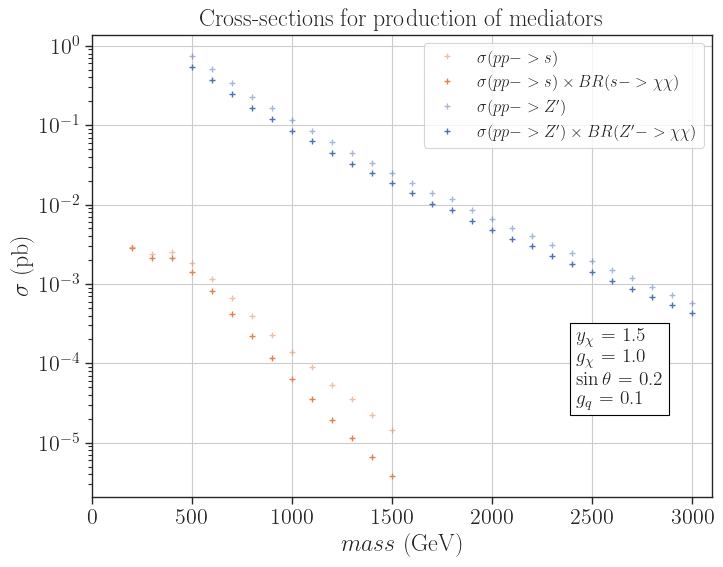

In [56]:
# plot cross-section
plt.figure(figsize=(8,6))

plt.plot(dataS['$m_{med}$'], dataS['x-sec pT-250 (pb)'], label=r'$\sigma(pp -> s)$', 
         color=colors['pp->sd'], alpha=0.5, marker='+', linestyle='')


plt.plot(dataS['$m_{med}$'], np.array(dataS['x-sec pT-250 (pb)'])*np.array(brS['$BR(med>\\chi\\chi)$']),
         label=r'$\sigma(pp -> s) \times BR(s -> \chi \chi) $', color=colors['pp->sd'], marker='+', linestyle='')


plt.plot(dataZ['$m_{med}$'], dataZ['x-sec pT-250 (pb)'], label=r'$\sigma(pp -> Z^{\prime})$', 
         color=colors['pp->zp'], alpha=0.5, marker='+', linestyle='')


plt.plot(dataZ['$m_{med}$'], np.array(dataZ['x-sec pT-250 (pb)'])*np.array(brZ['$BR(med>\\chi\\chi)$']),
         label=r'$\sigma(pp -> Z^{\prime}) \times BR(Z^{\prime} -> \chi \chi) $', color=colors['pp->zp'], 
         marker='+', linestyle='')

    
# plt.hlines(0.11, xmin=0.0, xmax=3100, linestyles='--', alpha=0.2, color='gray')
plt.yscale('log')

plt.title('Cross-sections for production of mediators')
plt.xlabel(r'$mass$ (GeV)')
plt.ylabel(r'$\sigma$ (pb)')

plt.text(0.78,0.2,textstr,fontsize=14,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.xlim(0.0, 3100)
plt.grid(which='major')

plt.legend(fontsize=12, loc='upper right')
plt.show()

In [38]:
prod = np.array(dataS['x-sec pT-250 (pb)'])*np.array(brS['$BR(med>\\chi\\chi)$'])
for i, m in enumerate(dataS['$m_{med}$']):
    print(m, prod[i])

200.0 0.002848240998833983
300.0 0.002131600294075236
400.0 0.0021317462709879147
500.0 0.0013978885581853481
600.0 0.000809515532797452
700.0 0.00041890137646357804
800.0 0.00022117092055600227
900.0 0.00011594652785839248
1000.0 6.284553664658055e-05
1100.0 3.585695445771015e-05
1200.0 1.9555679018280688e-05
1300.0 1.1628038764739553e-05
1400.0 6.583691758009919e-06
1500.0 3.8608883413925054e-06


In [39]:
prod = np.array(dataZ['x-sec pT-250 (pb)'])*np.array(brZ['$BR(med>\\chi\\chi)$'])
for i, m in enumerate(dataZ['$m_{med}$']):
    print(m, prod[i])

500.0 0.6863140950091111
600.0 0.4703881062088588
700.0 0.3085348450771416
800.0 0.20988621130704987
900.0 0.15079671404697242
1000.0 0.10511047252454246
1100.0 0.07816905706902041
1200.0 0.056036670872373885
1300.0 0.040901483946070426
1400.0 0.030922824344683332
1500.0 0.02315249826821702
1600.0 0.017307629816993502
1700.0 0.012895995847804398
1800.0 0.01069395660679099
1900.0 0.007767017423267222
2000.0 0.0060442416721115
2100.0 0.004647202974056714
2200.0 0.003716216138468176
2300.0 0.002848677581707109
2400.0 0.0022470227953211557
2500.0 0.001763000310720311
2600.0 0.0013778017997046798
2700.0 0.001088874527329324
2800.0 0.0008474686019723852
2900.0 0.0006703649232739173
3000.0 0.0005337506373741248
